# Bitcoin Daily Trading

In [19]:
from IPython.display import Image

# Data Overview

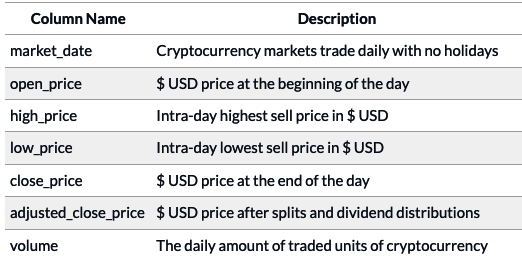

In [20]:
Image(filename='./resources/btc-table.png')

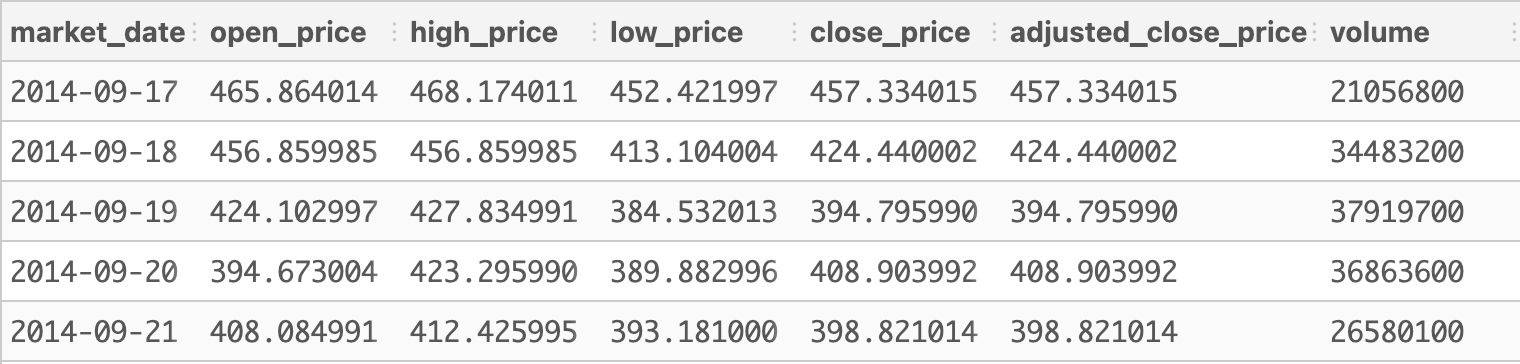

In [21]:
Image(filename='./resources/btc-sample.png')

# Data Cleaning

```sql
SELECT *
FROM trading.daily_btc
WHERE (
    open_price + high_price + low_price +
    close_price + adjusted_close_price + volume
) IS NULL
```

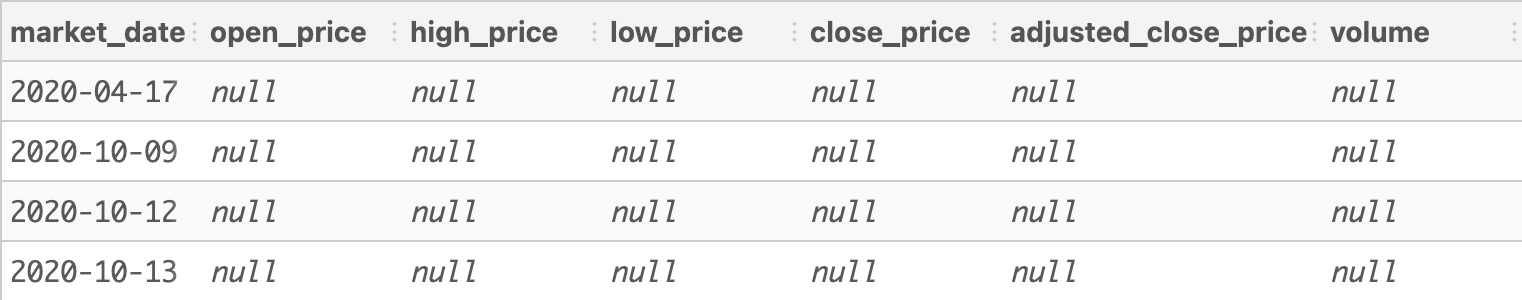

In [22]:
Image(filename='./resources/btc-unclean.png')

```sql
DROP TABLE IF EXISTS updated_daily_btc;
CREATE TEMP TABLE updated_daily_btc AS (

  SELECT 
    market_date,
    COALESCE(
      open_price,
      LAG(open_price) OVER w,
      LAG(open_price, 2) OVER w
    ) AS open_price,
    COALESCE(
      high_price,
      LAG(high_price) OVER w,
      LAG(high_price, 2) OVER w
    ) AS high_price,
    COALESCE(
      low_price,
      LAG(low_price) OVER w,
      LAG(low_price, 2) OVER w
    ) AS low_price,
    COALESCE(
      close_price,
      LAG(close_price) OVER w,
      LAG(close_price, 2) OVER w
    ) AS close_price,
    COALESCE(
      adjusted_close_price,
      LAG(adjusted_close_price) OVER w,
      LAG(adjusted_close_price, 2) OVER w
    ) AS adjusted_close_price,
    COALESCE(
      volume,
      LAG(volume) OVER w,
      LAG(volume, 2) OVER w
    ) AS volume
  FROM trading.daily_btc
  WINDOW
    w AS (ORDER BY market_date)
);

WITH cte_nulls AS (
  SELECT market_date
  FROM trading.daily_btc
  WHERE (
    open_price + high_price + low_price +
    close_price + adjusted_close_price + volume
  ) IS NULL
)
SELECT * 
FROM updated_daily_btc
WHERE market_date IN (SELECT market_date FROM cte_nulls);
```

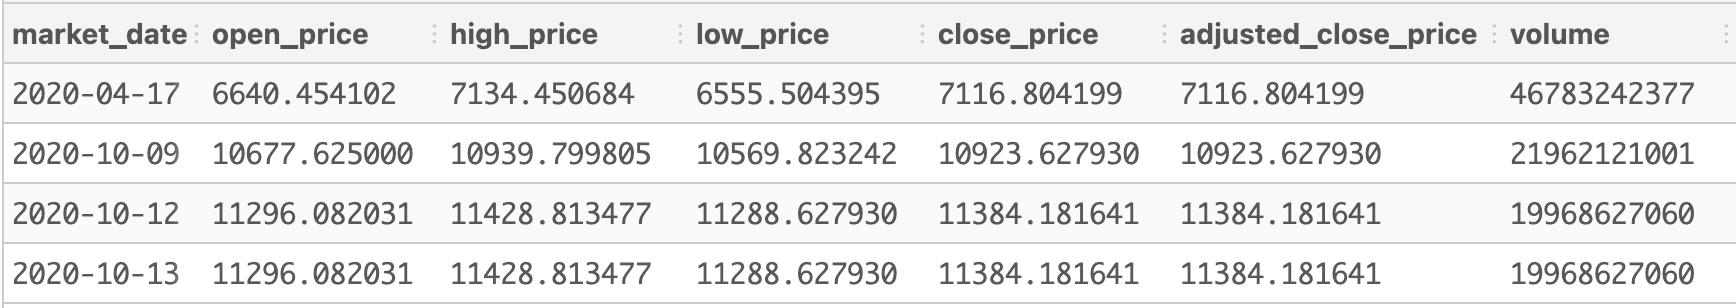

In [23]:
Image(filename='./resources/btc-cleaned.png')

# Questions

```1. What is the earliest and latest market_date values?```

```sql
SELECT 
  MIN(market_date) AS earliest_market_date,
  MAX(market_date) AS latest_market_date
FROM updated_daily_btc;
```

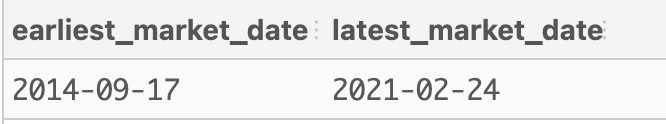

In [24]:
Image(filename='./resources/btc-1.png')

***

```2. What was the historic all-time high and low values for the close_price and their dates?```

```sql
SELECT 
  market_date AS "Date",
  close_price AS"Price"
FROM updated_daily_btc
WHERE close_price = (SELECT MIN(close_price) FROM updated_daily_btc)
UNION 
SELECT 
  market_date AS "Date",
  close_price AS"Price"
FROM updated_daily_btc
WHERE close_price = (SELECT MAX(close_price) FROM updated_daily_btc);
```

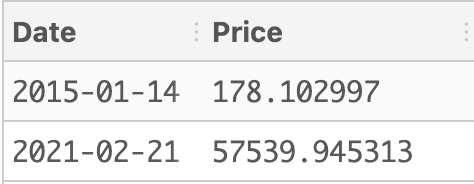

In [25]:
Image(filename='./resources/btc-2.png')

***

```3. Which date had the most volume traded and what was the close_price for that day?```

```sql
SELECT 
  market_date,
  volume,
  close_price
FROM updated_daily_btc
WHERE volume = (SELECT MAX(volume) FROM updated_daily_btc);
```

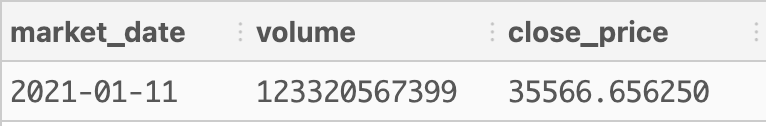

In [26]:
Image(filename='./resources/btc-3.png')

***

```4. How many days had a low_price price which was 10% less than the open_price?```

```sql
SELECT 
 COUNT(*) total_days
FROM updated_daily_btc
WHERE low_price < 0.90 * open_price;
```

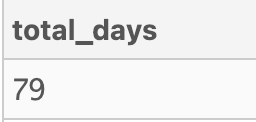

In [27]:
Image(filename='./resources/btc-4.png')

***

```5. What percentage of days have a higher close_price than open_price?```

```sql
SELECT 
  ROUND(100 * COUNT(*) FILTER(WHERE close_price > open_price)::NUMERIC / COUNT(*), 3) AS pct
FROM updated_daily_btc;
```

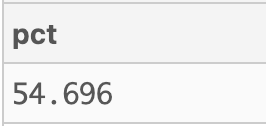

In [28]:
Image(filename='./resources/btc-5.png')

***

```6. What was the largest difference between high_price and low_price and which date did it occur?```

```sql
WITH cte_differences AS (
  SELECT 
    market_date,
    high_price-low_price AS difference
  FROM updated_daily_btc
)
SELECT
  market_date,
  difference
FROM cte_differences
WHERE difference = (SELECT MAX(difference) FROM cte_differences);
```

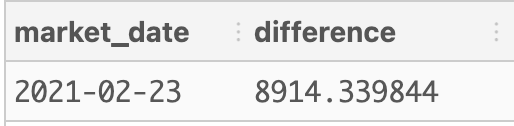

In [29]:
Image(filename='./resources/btc-6.png')

***

```7. If you invested $10,000 on the 1st January 2016 - how much is your investment worth in 1st of February 2021? Use the close_price for this calculation```

```sql
DROP TABLE IF EXISTS daily_return_rates;
CREATE TEMP TABLE daily_return_rates AS (
  SELECT 
    market_date,
    (close_price - open_price)::NUMERIC / open_price AS daily_return_rate
  FROM updated_daily_btc
  WHERE market_date BETWEEN '2016-01-01'::DATE AND '2021-02-01'::DATE
);

WITH RECURSIVE investment_values(market_date, investment_value) AS (
  SELECT
    market_date,
    10000::NUMERIC -- Initial Investment 
  FROM daily_return_rates 
  WHERE market_date = '2016-01-01'::DATE
  UNION ALL
  SELECT
    daily_return_rates.market_date,
    investment_values.investment_value*(1+daily_return_rates.daily_return_rate) 
  FROM 
    investment_values INNER JOIN daily_return_rates
    ON daily_return_rates.market_date = investment_values.market_date + 1
)
SELECT 
  market_date,
  ROUND(investment_value, 2) AS investment_value
FROM investment_values
WHERE market_date IN ('2016-01-01'::DATE,'2021-02-01'::DATE);
```

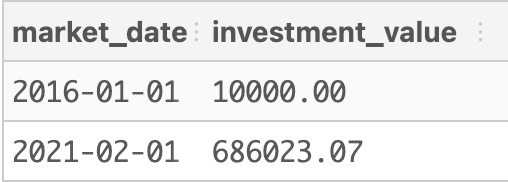

In [30]:
Image(filename='./resources/btc-7.png')